<a href="https://colab.research.google.com/github/MunJinSeo/MachineLearning/blob/main/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5(AAI107)_Team13_%EC%A3%BC%EA%B0%80%EB%8F%99%ED%96%A5%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Team 13 (서문진, 서혜인, 이정은) - 주가 이력 데이터와 네이버 금융정보 및 뉴스 감정 분석을 통한 주식 가격 예측

## 설명(배경 및 방향)

- 주식가격은 시계열 데이터 형태이기 때문에 보통 LSTM/RNN등 모델을 사용하여 시계열 예측하는 경우가 많고 예측 정확도 50%를 넘기기 쉽지 않다고 한다.
또한 최근 강화학습을 사용하여 정확도를 높인 사례나 논문도 있으나 이 역시 만족할만한 수준은 아니고, 우리의 학습 범위를 벗어난다.

- 주식은 외부 변수가 너무 많고, 국가간의 영향과 현재 경제상황에도 영향을 받는 경우가 많다. 
또한 주식매매에 참여한 수많은 참가자들의 심리와 복잡한 상호작용을 모델링하여 주식 가격을 예측하는 것은 아직 불가능에 가깝다고 보여진다.

- 특정 주식의 과거 패턴을 학습했더라도 오늘자 주식은 그 패턴을 따르지 않는 경우가 많고, 과거 패턴보다는 어제,오늘 외부 환경에 따라 영향을 많이 받는다. 그리고, 특정 종목 패턴을 학습하더라도 타 종목에 적용하기도 어렵울것으로 보인다.

- **따라서 우리는 주식 가격에 영향을 주는 외부 요인이 어떤것이 있는지 찾아보고, 연관관계가 높은 데이터를 활용하여 내일의 주식가격 상승/보합/하강 을 판단하는 multiclass classification 과제로 접근 해보고자 한다.** 

- 향후 주식을 매매(buy,sell) 시기를 판단하도록 도와주는 자동 매매 예측기 기반을 마련해보고자 한다.

주가에 영향 있어 보이는 외부 데이터 대상 후보

- 원달라 환율, 미국 국채금리, 미국 장단기 금리차
- 전날 미국 나스닥지수, 뉴욕지수 동향
- 종목 수익률 --제외(주가와 동일패턴)
- 전일 거래 동향 및 거래량 
- 기관매매동향 , 외국인매매동향
- 공매도 동향
- 뉴스 주식 관련 감성 (SNS 주식 관련 감성은 제외)
- 증시자금동향(고객,신용,혼합,채권) -- 대체(거래 동향으로 대체)

## 라이브러리 불러오기

금융/주식 데이터 수집용 패키지

* [FinanceData/FinanceDataReader: Financial data reader](https://github.com/FinanceData/FinanceDataReader)
* [FinanceDataReader 사용자 안내서 | FinanceData](https://financedata.github.io/posts/finance-data-reader-users-guide.html)

In [ ]:
# 금융/주식 데이터 수집용 패키지 설치
# colab 런타임 초기화 될때마다 다시 설치 필요
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinanceDataReader 를 fdr 별칭으로 불러오기
import FinanceDataReader as fdr

In [ ]:
START_DATE="2018-01-01" #가져올 데이터 초기 년도

In [ ]:
#'삼성전자': '005930'
#'셀트리온': '068270'
#'POSCO': '005490'
#'NAVER': '035420'
#------------------------------------
# Date : 주식시장 개장 날짜
# Open : 해당 개장일의 시가
# High : 해당 개장일의 고가
# Low  : 해당 개장일의 저가
# Close : 해당 개장일의 종가
# Volume : 해당 개장일의 거래량
# Change : 해당 개장일의 전날 대비 종가 상승률(음수면 하락 양수면 상승)
#------------------------------------
# KRX_df = fdr.DataReader('005930', '2018-01-01', '2022-06-03', exchange='KRX') # default exchange KRX
# df_samsung_stock = fdr.DataReader('005930', "2019", "2021")['Close']  # 2019~2020.12까지 종가
df_samsung_stock = fdr.DataReader('005930', START_DATE) #2018년 이후 ~ 현재 주가 전체
df_samsung_stock
#print(df_samsung_stock.head(10))
#print(df_samsung_stock.tail(10))


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
...,...,...,...,...,...,...
2022-05-30,67500,67800,66900,67700,14255484,0.018045
2022-05-31,67500,67500,66700,67400,24365002,-0.004431
2022-06-02,66600,67000,66400,66700,14959443,-0.010386


In [ ]:
df_samsung_stock["Close"].shift(periods=-1) # 내일자를 오늘자 데이터에 컬럼 추가 테스트

Date
2018-01-02    51620.0
2018-01-03    51080.0
2018-01-04    52120.0
2018-01-05    52020.0
2018-01-08    50400.0
               ...   
2022-05-27    67700.0
2022-05-30    67400.0
2022-05-31    66700.0
2022-06-02    66800.0
2022-06-03        NaN
Name: Close, Length: 1089, dtype: float64

In [ ]:
df_samsung_stock["Close"].shift(periods=1) # 어제것을 오늘자 데이터에 컬럼 추가 테스트

Date
2018-01-02        NaN
2018-01-03    51020.0
2018-01-04    51620.0
2018-01-05    51080.0
2018-01-08    52120.0
               ...   
2022-05-27    65900.0
2022-05-30    66500.0
2022-05-31    67700.0
2022-06-02    67400.0
2022-06-03    66700.0
Name: Close, Length: 1089, dtype: float64

In [ ]:
df_samsung_stock["Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in df_samsung_stock["Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1
df_samsung_stock

,Open,High,Low,Close,Volume,Change,Class
Date,,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177,1
2018-01-03,52540,52560,51420,51620,200270,0.011760,1
2018-01-04,52120,52180,50640,51080,233909,-0.010461,-1
2018-01-05,51300,52120,51200,52120,189623,0.020360,1
2018-01-08,52400,52520,51500,52020,167673,-0.001919,-1
...,...,...,...,...,...,...,...
2022-05-30,67500,67800,66900,67700,14255484,0.018045,1
2022-05-31,67500,67500,66700,67400,24365002,-0.004431,-1
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,-1


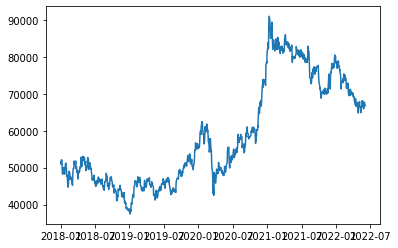

In [ ]:
#plt.plot(df_samsung_stock["Open"])
plt.plot(df_samsung_stock["Close"])

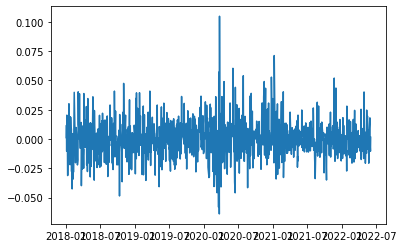

In [ ]:
plt.plot(df_samsung_stock["Change"])

In [ ]:
# KS11	KOSPI 지수
# KQ11	KOSDAQ 지수
# KS50	KOSPI 50 지수
# KS100	KOSPI 100 지수
# KRX100	KRX 100 지수
# KS200	KOSPI 200 지수

# 코스피 지수
KOSPI = fdr.DataReader("KS11", START_DATE)

In [ ]:
KOSPI["KOSPI_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in KOSPI["Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
KOSPI

,Close,Open,High,Low,Volume,Change,KOSPI_Class
Date,,,,,,,
2018-01-02,2479.65,2474.86,2481.02,2465.94,262200000.0,0.0049,1
2018-01-03,2486.35,2484.63,2493.40,2481.91,331100000.0,0.0027,1
2018-01-04,2466.46,2502.50,2502.50,2466.45,333840000.0,-0.0080,-1
2018-01-05,2497.52,2476.85,2497.52,2475.51,308770000.0,0.0126,1
2018-01-08,2513.28,2510.70,2515.37,2494.18,311430000.0,0.0063,1
...,...,...,...,...,...,...,...
2022-05-27,2638.05,2640.75,2644.71,2631.49,590810000.0,0.0098,1
2022-05-30,2669.66,2662.31,2672.74,2654.18,469800000.0,0.0120,1
2022-05-31,2685.90,2666.88,2685.90,2654.32,671680000.0,0.0061,1


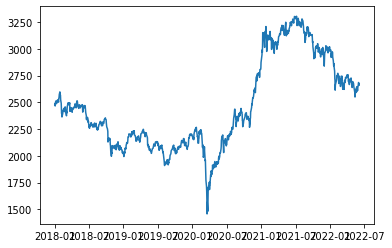

In [ ]:
plt.plot(KOSPI["Close"])

In [ ]:
# 원달러 환율
USD_KRX = fdr.DataReader("USD/KRW",START_DATE)

In [ ]:
USD_KRX["USD_KRX_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in USD_KRX["Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
USD_KRX

,Close,Open,High,Low,Change,USD_KRX_Class
Date,,,,,,
2018-01-01,1066.60,1067.38,1067.80,1065.61,-0.0007,-1
2018-01-02,1063.21,1066.60,1068.51,1059.97,-0.0032,-1
2018-01-03,1064.80,1062.88,1068.16,1062.48,0.0015,1
2018-01-04,1062.28,1065.13,1069.31,1061.53,-0.0024,-1
2018-01-05,1062.09,1061.83,1064.06,1060.20,-0.0002,-1
...,...,...,...,...,...,...
2022-06-01,1246.89,1242.48,1248.58,1240.29,0.0037,1
2022-06-02,1240.32,1247.23,1255.04,1240.67,-0.0053,-1
2022-06-03,1250.58,1241.14,1252.23,1238.47,0.0083,1


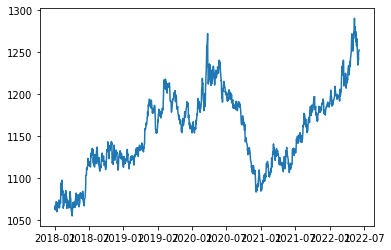

In [ ]:
plt.plot(USD_KRX["Close"])

In [ ]:
# 미국 국채 금리, 세계 경제 영향
DGS = fdr.DataReader(['DGS20', 'DGS10', 'DGS5', 'DGS1'],START_DATE, data_source='fred')

In [ ]:
DGS["DGS20_BeforeDay"] = DGS["DGS20"].shift(periods=1).copy() # 어제것을 오늘자 데이터에 붙이기 테스트
DGS["DGS20_Change"] = DGS["DGS20"] - DGS["DGS20_BeforeDay"]  # 오늘 - 어제 변경(차이)
DGS["DGS20_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in DGS["DGS20_Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

DGS["DGS10_BeforeDay"] = DGS["DGS10"].shift(periods=1).copy() # 어제것을 오늘자 데이터에 붙이기 테스트
DGS["DGS10_Change"] = DGS["DGS10"] - DGS["DGS10_BeforeDay"]  # 오늘 - 어제 변경(차이)
DGS["DGS10_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in DGS["DGS10_Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

DGS["DGS5_BeforeDay"] = DGS["DGS5"].shift(periods=1).copy() # 어제것을 오늘자 데이터에 붙이기 테스트
DGS["DGS5_Change"] = DGS["DGS5"] - DGS["DGS5_BeforeDay"]  # 오늘 - 어제 변경(차이)
DGS["DGS5_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in DGS["DGS5_Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

DGS["DGS1_BeforeDay"] = DGS["DGS1"].shift(periods=1).copy() # 어제것을 오늘자 데이터에 붙이기 테스트
DGS["DGS1_Change"] = DGS["DGS1"] - DGS["DGS1_BeforeDay"]  # 오늘 - 어제 변경(차이)
DGS["DGS1_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in DGS["DGS1_Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
DGS

,DGS20,DGS10,DGS5,DGS1,DGS20_BeforeDay,DGS20_Change,DGS20_Class,DGS10_BeforeDay,DGS10_Change,DGS10_Class,DGS5_BeforeDay,DGS5_Change,DGS5_Class,DGS1_BeforeDay,DGS1_Change,DGS1_Class
DATE,,,,,,,,,,,,,,,,
2018-01-02,2.64,2.46,2.25,1.83,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
2018-01-03,2.62,2.44,2.25,1.81,2.64,-0.02,-1,2.46,-0.02,-1,2.25,0.00,0,1.83,-0.02,-1
2018-01-04,2.62,2.46,2.27,1.82,2.62,0.00,0,2.44,0.02,1,2.25,0.02,1,1.81,0.01,1
2018-01-05,2.64,2.47,2.29,1.80,2.62,0.02,1,2.46,0.01,1,2.27,0.02,1,1.82,-0.02,-1
2018-01-08,2.65,2.49,2.29,1.79,2.64,0.01,1,2.47,0.02,1,2.29,0.00,0,1.80,-0.01,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,3.16,2.74,2.71,2.01,3.18,-0.02,-1,2.75,-0.01,-1,2.70,0.01,1,1.99,0.02,1
2022-05-30,3.16,2.74,2.71,2.01,3.16,0.00,0,2.74,0.00,0,2.71,0.00,0,2.01,0.00,0
2022-05-31,3.28,2.85,2.81,2.08,3.16,0.12,1,2.74,0.11,1,2.71,0.10,1,2.01,0.07,1


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


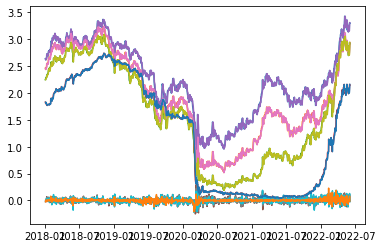

In [ ]:
plt.plot(DGS)

In [ ]:
# 미국 장단기 금리차, 장단기 금리차가 줄어들수록 경제위기 발생
# 장기금리(10년물 국채 수익률) - 단기금리(2년물 국채 수익률)

T10Y2Y = fdr.DataReader("T10Y2Y", START_DATE, data_source="fred")

In [ ]:
T10Y2Y["T10Y2Y_BeforeDay"] = T10Y2Y["T10Y2Y"].shift(periods=1).copy() # 어제것을 오늘자 데이터에 붙이기 테스트
T10Y2Y["T10Y2Y_Change"] = T10Y2Y["T10Y2Y"] - T10Y2Y["T10Y2Y_BeforeDay"]  # 오늘 - 어제 변경(차이)
T10Y2Y["T10Y2Y_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in T10Y2Y["T10Y2Y_Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
T10Y2Y

,T10Y2Y,T10Y2Y_BeforeDay,T10Y2Y_Change,T10Y2Y_Class
DATE,,,,
2018-01-02,0.54,NaN,NaN,0
2018-01-03,0.50,0.54,-0.04,-1
2018-01-04,0.50,0.50,0.00,0
2018-01-05,0.51,0.50,0.01,1
2018-01-08,0.53,0.51,0.02,1
...,...,...,...,...
2022-05-31,0.32,0.27,0.05,1
2022-06-01,0.28,0.32,-0.04,-1
2022-06-02,0.27,0.28,-0.01,-1


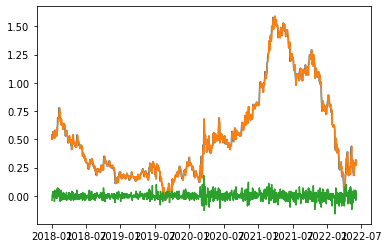

In [ ]:
plt.plot(T10Y2Y)

In [ ]:
# 한국:"KRX", 뉴욕:"NYSE", 상해:"SSE" ...
# 코스피:"KOSPI", 코스닥:"KOSDAQ", 코넥스:"KONEX", S&P500:"S&P500" ...
# NASDAQ	나스닥 종목
# NYSE	뉴욕 증권거래소 종목
# AMEX	AMEX 종목
# SP500	S&P500 종목

# NYSE = fdr.StockListing('NYSE') # 뉴욕거래소

In [ ]:
#NYSE

In [ ]:
# DJI	다우존스 지수
# IXIC	나스닥 지수
# US500	S&P 500 지수
# VIX	S&P 500 VIX
# JP225	닛케이 225 선물
# STOXX50E	Euro Stoxx 50
# CSI300	CSI 300(중국)
# HSI	항생(홍콩)
# FTSE	영국 FTSE
# DAX	독일 DAX 30
# CAC	프랑스 CAC 40

# DJI	다우존스 지수
DJI = fdr.DataReader('DJI', START_DATE, exchange='NYSE')

In [ ]:
DJI["DJI_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in DJI["Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
DJI

,Close,Open,High,Low,Volume,Change,DJI_Class
Date,,,,,,,
2018-01-02,24824.01,24809.35,24864.19,24741.70,341130000.0,0.0042,1
2018-01-03,24922.68,24850.45,24941.92,24825.55,456790000.0,0.0040,1
2018-01-04,25075.13,24964.86,25105.96,24963.27,403280000.0,0.0061,1
2018-01-05,25295.87,25114.92,25299.79,25112.01,358020000.0,0.0088,1
2018-01-08,25283.00,25308.40,25311.99,25235.41,341390000.0,-0.0005,-1
...,...,...,...,...,...,...,...
2022-05-27,33213.55,32735.09,33213.62,32688.70,309630000.0,0.0176,1
2022-05-31,32991.97,33027.03,33240.15,32754.75,444890000.0,-0.0067,-1
2022-06-01,32813.10,33156.31,33270.83,32585.15,324670000.0,-0.0054,-1


In [ ]:
# IXIC	나스닥 지수
IXIC = fdr.DataReader('IXIC', START_DATE, exchange='NASDAQ')

In [ ]:
IXIC["IXIC_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in IXIC["Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
IXIC

,Close,Open,High,Low,Volume,Change,IXIC_Class
Date,,,,,,,
2018-01-02,7006.90,6937.65,7006.91,6924.08,462200000.0,0.0150,1
2018-01-03,7065.53,7017.07,7069.15,7016.70,483920000.0,0.0084,1
2018-01-04,7077.91,7089.50,7098.05,7072.38,493870000.0,0.0018,1
2018-01-05,7136.56,7105.74,7137.04,7097.08,476410000.0,0.0083,1
2018-01-08,7157.39,7135.38,7161.35,7124.09,497210000.0,0.0029,1
...,...,...,...,...,...,...,...
2022-06-01,11994.46,12176.89,12237.93,11901.43,940600000.0,-0.0072,-1
2022-06-02,12316.90,11945.57,12320.12,11901.45,916660000.0,0.0269,1
2022-06-03,12012.73,12097.12,12167.44,11966.62,837590000.0,-0.0247,-1


In [ ]:
# 수집한 데이터 합치기 1
#all_data = df_samsung_stock.copy()
all_data = pd.DataFrame({})
all_data["Close"] = df_samsung_stock["Close"].copy()
all_data["Change"] = df_samsung_stock["Change"].copy()
all_data["Class"] = df_samsung_stock["Class"].copy()

In [ ]:
all_data["NextDay_Close"] = df_samsung_stock["Close"].shift(periods=-1).copy() # 내일자를 오늘자 데이터에 붙이기
all_data["NextDay_Change"] = df_samsung_stock["Change"].shift(periods=-1).copy() # 내일자를 오늘자 데이터에 붙이기
all_data["NextDay_Class"] = [ 1 if cc > 0 else (-1 if cc < 0 else 0) for cc in all_data["NextDay_Change"] ] # 분류 : 상승 1, 보함 0 , 하락 -1

In [ ]:
all_data["KOSPI_Close"] = KOSPI["Close"].copy()
all_data["KOSPI_Change"] = KOSPI["Change"].copy()
all_data["KOSPI_Class"] = KOSPI["KOSPI_Class"].copy()

In [ ]:
all_data["USD_KRX_Close"] = USD_KRX["Close"].copy()
all_data["USD_KRX_Change"] = USD_KRX["Change"].copy()
all_data["USD_KRX_Class"] = USD_KRX["USD_KRX_Class"].copy()

In [ ]:
# 'DGS20', 'DGS10', 'DGS5', 'DGS1'
all_data["DGS20"] = DGS["DGS20"].copy()
all_data["DGS20_Change"] = DGS["DGS20_Change"].copy()
all_data["DGS20_Class"] = DGS["DGS20_Class"].copy()

all_data["DGS10"] = DGS["DGS10"].copy()
all_data["DGS10_Change"] = DGS["DGS10_Change"].copy()
all_data["DGS10_Class"] = DGS["DGS10_Class"].copy()

all_data["DGS5"] = DGS["DGS5"].copy()
all_data["DGS5_Change"] = DGS["DGS5_Change"].copy()
all_data["DGS5_Class"] = DGS["DGS5_Class"].copy()

all_data["DGS1"] = DGS["DGS1"].copy()
all_data["DGS1_Change"] = DGS["DGS1_Change"].copy()
all_data["DGS1_Class"] = DGS["DGS1_Class"].copy()

In [ ]:
all_data["T10Y2Y"] = T10Y2Y["T10Y2Y"].copy()
all_data["T10Y2Y_Change"] = T10Y2Y["T10Y2Y_Change"].copy()
all_data["T10Y2Y_Class"] = T10Y2Y["T10Y2Y_Class"].copy()

In [ ]:
all_data["DJI_Close"] = DJI["Close"].copy()
all_data["DJI_Change"] = DJI["Change"].copy()
all_data["DJI_Class"] = DJI["DJI_Class"].copy()

In [ ]:
all_data["IXIC_Close"] = IXIC["Close"].copy()
all_data["IXIC_Change"] = IXIC["Change"].copy()
all_data["IXIC_Class"] = IXIC["IXIC_Class"].copy()

In [ ]:
all_data

,Close,Change,Class,NextDay_Close,NextDay_Change,NextDay_Class,KOSPI_Close,KOSPI_Change,KOSPI_Class,USD_KRX_Close,...,DGS1_Class,T10Y2Y,T10Y2Y_Change,T10Y2Y_Class,DJI_Close,DJI_Change,DJI_Class,IXIC_Close,IXIC_Change,IXIC_Class
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,51020,0.001177,1,51620.0,0.011760,1,2479.65,0.0049,1,1063.21,...,0.0,0.54,NaN,0.0,24824.01,0.0042,1.0,7006.90,0.0150,1.0
2018-01-03,51620,0.011760,1,51080.0,-0.010461,-1,2486.35,0.0027,1,1064.80,...,-1.0,0.50,-0.04,-1.0,24922.68,0.0040,1.0,7065.53,0.0084,1.0
2018-01-04,51080,-0.010461,-1,52120.0,0.020360,1,2466.46,-0.0080,-1,1062.28,...,1.0,0.50,0.00,0.0,25075.13,0.0061,1.0,7077.91,0.0018,1.0
2018-01-05,52120,0.020360,1,52020.0,-0.001919,-1,2497.52,0.0126,1,1062.09,...,-1.0,0.51,0.01,1.0,25295.87,0.0088,1.0,7136.56,0.0083,1.0
2018-01-08,52020,-0.001919,-1,50400.0,-0.031142,-1,2513.28,0.0063,1,1068.86,...,-1.0,0.53,0.02,1.0,25283.00,-0.0005,-1.0,7157.39,0.0029,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30,67700,0.018045,1,67400.0,-0.004431,-1,2669.66,0.0120,1,1234.85,...,0.0,0.27,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-31,67400,-0.004431,-1,66700.0,-0.010386,-1,2685.90,0.0061,1,1242.26,...,1.0,0.32,0.05,1.0,32991.97,-0.0067,-1.0,12081.39,-0.0041,-1.0
2022-06-02,66700,-0.010386,-1,66800.0,0.001499,1,2658.99,-0.0100,-1,1240.32,...,-1.0,0.27,-0.01,-1.0,33248.02,0.0133,1.0,12316.90,0.0269,1.0


In [ ]:
corr_matrix = all_data.corr() # 상관관계 계산

In [ ]:
print(corr_matrix["NextDay_Change"].sort_values(ascending=False)) # 상관관계 찾아보기

NextDay_Change    1.000000
NextDay_Class     0.760747
IXIC_Change       0.232736
DJI_Change        0.196881
IXIC_Class        0.183495
DJI_Class         0.168003
DGS1_Class        0.085716
DGS1_Change       0.067065
Class             0.042184
NextDay_Close     0.030259
DGS5_Class        0.011399
Change            0.005466
DGS5_Change       0.004878
KOSPI_Class       0.003137
USD_KRX_Close    -0.003123
T10Y2Y           -0.004955
DGS20_Class      -0.005003
IXIC_Close       -0.005844
DGS10_Class      -0.006053
DGS10_Change     -0.010030
DJI_Close        -0.016430
DGS1             -0.025921
DGS20_Change     -0.025970
Close            -0.034855
KOSPI_Close      -0.042690
DGS5             -0.047774
T10Y2Y_Class     -0.048550
DGS10            -0.049557
DGS20            -0.052253
T10Y2Y_Change    -0.058347
KOSPI_Change     -0.066569
USD_KRX_Class    -0.096950
USD_KRX_Change   -0.133206
Name: NextDay_Change, dtype: float64


In [ ]:
print(corr_matrix["NextDay_Class"].sort_values(ascending=False)) # 상관관계 찾아보기

NextDay_Class     1.000000
NextDay_Change    0.760482
IXIC_Change       0.190858
DJI_Change        0.166128
IXIC_Class        0.165934
DJI_Class         0.139835
DGS1_Class        0.051607
DGS1_Change       0.042341
DGS5_Change       0.031002
Class             0.029871
DGS10_Change      0.028338
DGS20_Change      0.023600
Change            0.014008
DGS1              0.006318
DGS10_Class       0.006200
KOSPI_Class       0.003889
DGS20_Class       0.002059
USD_KRX_Close    -0.002458
DGS5_Class       -0.003014
T10Y2Y_Class     -0.010350
NextDay_Close    -0.017096
T10Y2Y_Change    -0.019967
DGS5             -0.024038
DGS10            -0.030374
KOSPI_Change     -0.033964
DGS20            -0.037897
T10Y2Y           -0.040129
DJI_Close        -0.048445
IXIC_Close       -0.049201
Close            -0.067764
USD_KRX_Class    -0.070601
KOSPI_Close      -0.074624
USD_KRX_Change   -0.096477
Name: NextDay_Class, dtype: float64


In [ ]:
print(corr_matrix["NextDay_Close"].sort_values(ascending=False)) # 상관관계 찾아보기

NextDay_Close     1.000000
Close             0.997766
IXIC_Close        0.928449
KOSPI_Close       0.905778
DJI_Close         0.884593
T10Y2Y            0.809936
DGS1_Change       0.091959
DGS5_Change       0.088369
DGS20_Class       0.073072
DGS10_Change      0.068972
DGS10_Class       0.065145
DGS20_Change      0.058397
DGS5_Class        0.057023
KOSPI_Change      0.038196
DGS1_Class        0.035908
USD_KRX_Close     0.035548
Change            0.032036
NextDay_Change    0.030814
T10Y2Y_Class      0.016406
DJI_Change        0.015743
KOSPI_Class       0.012836
USD_KRX_Change    0.003703
IXIC_Change       0.001655
DJI_Class         0.000495
IXIC_Class       -0.005023
T10Y2Y_Change    -0.009647
Class            -0.015157
NextDay_Class    -0.017096
USD_KRX_Class    -0.021360
DGS20            -0.331550
DGS10            -0.438109
DGS5             -0.524946
DGS1             -0.738423
Name: NextDay_Close, dtype: float64


In [ ]:
# KRX 주식 정보 크롤링
# 참고 : https://github.com/sharebook-kr/pykrx

!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 51 kB 529 kB/s 
     |████████████████████████████████| 251 kB 47.1 MB/s 


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
from pykrx import stock
from pykrx import bond

In [ ]:
DAY_START = '20180101'
DAY_END = '20220603'
Samsung_id = '005930'

In [ ]:
# 일자별 DIV/BPS/PER/EPS 조회
df_samsung_fundamental = stock.get_market_fundamental(DAY_START, DAY_END, Samsung_id, freq="d") # frequency 파라미터(d/m/y)
print(df_samsung_fundamental)

                BPS    PER   PBR     EPS   DIV    DPS
날짜                                                   
2018-01-02  1156530  16.15  2.21  157967  1.12  28500
2018-01-03  1156530  16.34  2.23  157967  1.10  28500
2018-01-04  1156530  16.17  2.21  157967  1.12  28500
2018-01-05  1156530  16.50  2.25  157967  1.09  28500
2018-01-08  1156530  16.47  2.25  157967  1.10  28500
...             ...    ...   ...     ...   ...    ...
2022-05-27    43611  11.51  1.52    5777  2.17   1444
2022-05-30    43611  11.72  1.55    5777  2.13   1444
2022-05-31    43611  11.67  1.55    5777  2.14   1444
2022-06-02    43611  11.55  1.53    5777  2.16   1444
2022-06-03    43611  11.56  1.53    5777  2.16   1444

[1089 rows x 6 columns]


In [ ]:
# 일자별 거래실적 추이 (거래대금)
df_samsung_trading_value = stock.get_market_trading_value_by_date(DAY_START, DAY_END, Samsung_id) # 파리미터 on='매도/매수'
print(df_samsung_trading_value)


                    기관합계         기타법인            개인         외국인합계  전체
날짜                                                                   
2018-01-02  -59801412000  39785017000   66587603000  -46571208000   0
2018-01-03 -123156838000  16642029000  -12050080000  118564889000   0
2018-01-04 -101949136000  31029876000    2454905000   68464355000   0
2018-01-05   14748253000  15496543000  -55262640000   25017844000   0
2018-01-08  -46525536000  43960256000  -21346810000   23912090000   0
...                  ...          ...           ...           ...  ..
2022-05-27  151176871900  -1094897700  -49251179800 -100830794400   0
2022-05-30   82410643100    228470400 -188160047400  105520933900   0
2022-05-31 -235626328200   4186219500  134633269700   96806839000   0
2022-06-02 -214023092200   9404746600  240927784700  -36309439100   0
2022-06-03   57253486400   -471150100  -23834896300  -32947440000   0

[1086 rows x 5 columns]


In [ ]:
# 일자별 거래실적 추이 (거래대금) - 시장 전체
df_all_stock_trading_value = stock.get_market_trading_value_by_date(DAY_START, DAY_END, "KOSPI") # KOSPI, KOSDAQ, KONEX, ALL 가능
print(df_all_stock_trading_value)

                    기관합계         기타법인            개인          외국인합계  전체
날짜                                                                    
2018-01-02 -276231823161  39547173315  -26748556121   263433205967   0
2018-01-03 -398032953865  22955583784  -24158623194   399235993275   0
2018-01-04 -384461413994   4343337186   44246512095   335871564713   0
2018-01-05  102182433145  22585493711 -370491328497   245723401641   0
2018-01-08  -87326837178  47673588133 -351177151300   390830400345   0
...                  ...          ...           ...            ...  ..
2022-05-27  554354708900 -83522575463 -744728157185   273896023748   0
2022-05-30  420357934610  32435862413 -802108858710   349315061687   0
2022-05-31 -585434565666  35723170377 -508991020406  1058702415695   0
2022-06-02 -748869787728  43089605237  792765717194   -86985534703   0
2022-06-03  321975044646    989279357 -310351813680   -12612510323   0

[1089 rows x 5 columns]


In [ ]:
# 일자별 외국인 보유량 및 외국인 한도소진률
df_samsung_foreign = stock.get_exhaustion_rates_of_foreign_investment(DAY_START, DAY_END, Samsung_id)
print(df_samsung_foreign)

                 상장주식수        보유수량       지분율        한도수량     한도소진률
날짜                                                                
2018-01-02   129098494    68089226  52.75000   129098494  52.75000
2018-01-03   129098494    68095088  52.75000   129098494  52.75000
2018-01-04   129098494    68171223  52.81250   129098494  52.81250
2018-01-05   129098494    68192680  52.81250   129098494  52.81250
2018-01-08   129098494    68203391  52.84375   129098494  52.84375
...                ...         ...       ...         ...       ...
2022-05-27  5969782550  3022334918  50.62500  5969782550  50.62500
2022-05-30  5969782550  3020994714  50.59375  5969782550  50.59375
2022-05-31  5969782550  3021796730  50.62500  5969782550  50.62500
2022-06-02  5969782550  3021798337  50.62500  5969782550  50.62500
2022-06-03  5969782550  3020673881  50.59375  5969782550  50.59375

[1089 rows x 5 columns]


In [ ]:
# 일자별 종목 공매도 현황
df_samsung_shorting = stock.get_shorting_status_by_date(DAY_START, DAY_END, Samsung_id)
print(df_samsung_shorting)

               거래량     잔고수량         거래대금          잔고금액
날짜                                                    
2018-01-02    1266    29723   3229159000   75823373000
2018-01-03    2440    31061   6294903000   80168441000
2018-01-04     588    32137   1519752000   82077898000
2018-01-05   14204    34186  36823189000   89088716000
2018-01-08    3781    32530   9829402000   84610530000
...            ...      ...          ...           ...
2022-05-26  798710  7677117  52790214200  505922010300
2022-05-27  532844  7600976  35460245200  505464904000
2022-05-30  344490  7537085  23213929000  510260654500
2022-05-31  372140  7699848  24953064900  518969755200
2022-06-02  264556  6662284  17641456100  444374342800

[1088 rows x 4 columns]


In [ ]:
# 일자별 투자자별 공매도 거래 현황
df_KOSPI_shorting_investor = stock.get_shorting_investor_volume_by_date(DAY_START, DAY_END, "KOSPI")
print(df_KOSPI_shorting_investor)


                 기관      개인      외국인  기타        합계
날짜                                                
2018-01-02  1910431    8162  6199347   0   8117940
2018-01-03  1124108   15388  5861426   0   7000922
2018-01-04  2250404    9091  5610926   0   7870421
2018-01-05  2346393   26271  6356160   0   8728824
2018-01-08  1826219   10661  5481423   0   7318303
...             ...     ...      ...  ..       ...
2022-05-27  1175825  195432  5610456   0   6981713
2022-05-30  1221866  212159  6270816   0   7704841
2022-05-31  1785899  292691  9174136   0  11252726
2022-06-02  1346907  409278  9272285   0  11028470
2022-06-03  1276973  102403  5895048   0   7274424

[1089 rows x 5 columns]


In [ ]:
# 수집한 데이터 합치기 2 -- Change, Calss 값 계산 후 Scaling 해야할듯함
all_data[df_samsung_fundamental.keys()] = df_samsung_fundamental.copy() # 일자별 DIV/BPS/PER/EPS

In [ ]:
all_data["종목거래실적_기관"] = df_samsung_trading_value["기관합계"].copy() # 일자별 거래실적 추이 (거래대금)
all_data["종목거래실적_외국인"] = df_samsung_trading_value["외국인합계"].copy() # 일자별 거래실적 추이 (거래대금)

In [ ]:
all_data["시장거래실적_기관"] = df_all_stock_trading_value["기관합계"].copy() # 일자별 거래실적 추이 (거래대금) - 시장 전체
all_data["시장거래실적_외국인"] = df_all_stock_trading_value["외국인합계"].copy() # 일자별 거래실적 추이 (거래대금) - 시장 전체

In [ ]:
all_data["종목_외국인보유수량"] = df_samsung_foreign["보유수량"].copy() # 일자별 외국인 보유량 및 외국인 한도소진률
all_data["종목_외국인지분율"] = df_samsung_foreign["지분율"].copy() # 일자별 외국인 보유량 및 외국인 한도소진률

In [ ]:
all_data["종목공매도_거래량"] = df_samsung_shorting["거래량"].copy() # 일자별 종목 공매도 현황
all_data["종목공매도_잔고수량"] = df_samsung_shorting["잔고수량"].copy() # 일자별 종목 공매도 현황

In [ ]:
all_data["시장_공매도_기관"] = df_KOSPI_shorting_investor["기관"].copy() # 일자별 투자자별 공매도 거래 현황
all_data["시장_공매도_외국인"] = df_KOSPI_shorting_investor["외국인"].copy() # 일자별 투자자별 공매도 거래 현황

In [ ]:
all_data

,Close,Change,Class,NextDay_Close,NextDay_Change,NextDay_Class,KOSPI_Close,KOSPI_Change,KOSPI_Class,USD_KRX_Close,...,종목거래실적_기관,종목거래실적_외국인,시장거래실적_기관,시장거래실적_외국인,종목_외국인보유수량,종목_외국인지분율,종목공매도_거래량,종목공매도_잔고수량,시장_공매도_기관,시장_공매도_외국인
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,51020,0.001177,1,51620.0,0.011760,1,2479.65,0.0049,1,1063.21,...,-5.980141e+10,-4.657121e+10,-276231823161,263433205967,68089226,52.75000,1266.0,29723.0,1910431,6199347
2018-01-03,51620,0.011760,1,51080.0,-0.010461,-1,2486.35,0.0027,1,1064.80,...,-1.231568e+11,1.185649e+11,-398032953865,399235993275,68095088,52.75000,2440.0,31061.0,1124108,5861426
2018-01-04,51080,-0.010461,-1,52120.0,0.020360,1,2466.46,-0.0080,-1,1062.28,...,-1.019491e+11,6.846436e+10,-384461413994,335871564713,68171223,52.81250,588.0,32137.0,2250404,5610926
2018-01-05,52120,0.020360,1,52020.0,-0.001919,-1,2497.52,0.0126,1,1062.09,...,1.474825e+10,2.501784e+10,102182433145,245723401641,68192680,52.81250,14204.0,34186.0,2346393,6356160
2018-01-08,52020,-0.001919,-1,50400.0,-0.031142,-1,2513.28,0.0063,1,1068.86,...,-4.652554e+10,2.391209e+10,-87326837178,390830400345,68203391,52.84375,3781.0,32530.0,1826219,5481423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,66500,0.009105,1,67700.0,0.018045,1,2638.05,0.0098,1,1251.99,...,1.511769e+11,-1.008308e+11,554354708900,273896023748,3022334918,50.62500,532844.0,7600976.0,1175825,5610456
2022-05-30,67700,0.018045,1,67400.0,-0.004431,-1,2669.66,0.0120,1,1234.85,...,8.241064e+10,1.055209e+11,420357934610,349315061687,3020994714,50.59375,344490.0,7537085.0,1221866,6270816
2022-05-31,67400,-0.004431,-1,66700.0,-0.010386,-1,2685.90,0.0061,1,1242.26,...,-2.356263e+11,9.680684e+10,-585434565666,1058702415695,3021796730,50.62500,372140.0,7699848.0,1785899,9174136


In [ ]:
corr_matrix2 = all_data.corr() # 상관관계 계산 2

In [ ]:
print(corr_matrix2["NextDay_Change"].sort_values(ascending=False)) # 상관관계 찾아보기

NextDay_Change    1.000000
NextDay_Class     0.760482
IXIC_Change       0.231333
DJI_Change        0.196179
IXIC_Class        0.182426
DJI_Class         0.166938
DGS1_Class        0.087185
DGS1_Change       0.068284
종목거래실적_외국인        0.044925
Class             0.043362
종목_외국인지분율         0.043341
NextDay_Close     0.030814
시장거래실적_외국인        0.022430
DGS5_Class        0.012636
종목공매도_잔고수량        0.012350
종목거래실적_기관         0.007798
DGS5_Change       0.005621
PER               0.005570
Change            0.005546
KOSPI_Class       0.004158
종목_외국인보유수량        0.002214
BPS              -0.000778
USD_KRX_Close    -0.000928
DIV              -0.000981
DGS20_Class      -0.003817
DPS              -0.004759
DGS10_Class      -0.004850
EPS              -0.005008
IXIC_Close       -0.005184
T10Y2Y           -0.005633
시장거래실적_기관        -0.007658
DGS10_Change     -0.009092
DJI_Close        -0.015264
DGS1             -0.024899
DGS20_Change     -0.025311
Close            -0.034248
KOSPI_Close      -0.042187
D

In [ ]:
print(corr_matrix2["NextDay_Class"].sort_values(ascending=False)) # 상관관계 찾아보기

NextDay_Class     1.000000
NextDay_Change    0.760482
IXIC_Change       0.190858
DJI_Change        0.166128
IXIC_Class        0.165934
DJI_Class         0.139835
종목_외국인지분율         0.061109
종목거래실적_외국인        0.055466
DGS1_Class        0.051607
DGS1_Change       0.042341
DGS5_Change       0.031002
Class             0.029871
DGS10_Change      0.028338
DGS20_Change      0.023600
시장거래실적_외국인        0.022953
종목공매도_잔고수량        0.020580
Change            0.014008
종목_외국인보유수량        0.013707
DGS1              0.006318
DGS10_Class       0.006200
KOSPI_Class       0.003889
DGS20_Class       0.002059
USD_KRX_Close    -0.002458
DGS5_Class       -0.003014
BPS              -0.007415
EPS              -0.008616
T10Y2Y_Class     -0.010350
DPS              -0.013780
종목거래실적_기관        -0.014853
NextDay_Close    -0.017096
종목공매도_거래량        -0.019502
시장거래실적_기관        -0.019834
T10Y2Y_Change    -0.019967
DIV              -0.021301
DGS5             -0.024038
시장_공매도_외국인       -0.027969
DGS10            -0.030374
시

In [ ]:
print(corr_matrix2["NextDay_Close"].sort_values(ascending=False)) # 상관관계 찾아보기

NextDay_Close     1.000000
Close             0.997766
IXIC_Close        0.928449
KOSPI_Close       0.905778
DJI_Close         0.884593
PER               0.883146
T10Y2Y            0.809936
PBR               0.704475
DIV               0.383765
종목_외국인보유수량        0.101075
DGS1_Change       0.091959
DGS5_Change       0.088369
DGS10_Change      0.068972
DGS20_Change      0.058397
KOSPI_Change      0.038196
USD_KRX_Close     0.035548
Change            0.032036
NextDay_Change    0.030814
DJI_Change        0.015743
USD_KRX_Change    0.003703
IXIC_Change       0.001655
T10Y2Y_Change    -0.009647
시장거래실적_외국인       -0.044856
종목거래실적_외국인       -0.104853
DPS              -0.116967
BPS              -0.180690
시장거래실적_기관        -0.187534
종목거래실적_기관        -0.198682
종목공매도_거래량        -0.201426
EPS              -0.210591
종목공매도_잔고수량       -0.282848
종목_외국인지분율        -0.299002
시장_공매도_외국인       -0.308207
DGS20            -0.331550
시장_공매도_기관        -0.358432
DGS10            -0.438109
DGS5             -0.524946
D